# LSTM Word-Level Generation

In [5]:
import pandas as pd
import random
import numpy as np

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
corpus = open('/content/drive/MyDrive/DA-23/lab4/Pr_9/shevchenko.txt','r').readlines()

In [8]:
for i in range(5):
  print(corpus[random.randint(0,len(corpus))].strip('\n'))

"Не потурай", - може, скажеш,
Поховали громадою
А хвилi на той бiк iдуть та ревуть.
Прощай же, друже! Нi хвали,
Зiлля дива наробило -


In [9]:
import re
import string

# example of text cleaning function
def clean_text(text):
    # credit to chatGPT
    # Regular expression to match numbers
    pattern = r'[%s]+' % re.escape(',.;!?')

    # Function to add whitespace to the matched numbers
    def add_whitespace(match):
        return ' '+match.group(0)  # Appending a whitespace after the matched substring

    # Replace the matched numbers with the matched number plus whitespace
    text = re.sub(pattern, add_whitespace, text)
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub(pattern, add_whitespace, text)
    #text = re.sub("\d", " ", text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    text = ' '.join([ (word) for word in text.split(' ')])
    return text

In [10]:
sample = corpus[random.randint(0,len(corpus))]
print(sample)
print(clean_text(sample))

print()

corpus = [clean_text(x) for x in corpus]

for i in range(5):
  print(corpus[random.randint(0,len(corpus))])

В рiцi Каялi. I на тiлi,

в рiцi каялi . i на тiлi , 

вийшла з хати: "чи йти , чи нi ? 
жаль душу згубити . 
неначе скажений ; то стогне , то виє: 
i дитини мати . 
чом вас лихо не приспало , 


In [11]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize(data, style='cool_r'):
    text = ''
    for msg in data:
        msg = str(msg).lower()
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="white",colormap  = style).generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

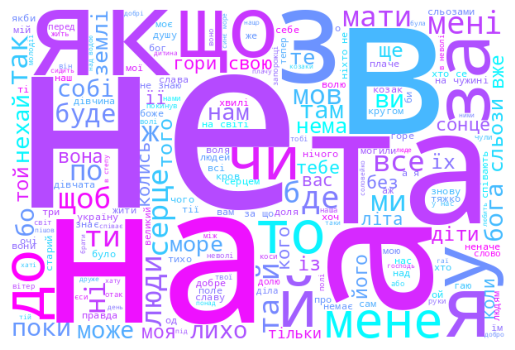

In [12]:
visualize(corpus)

In [13]:
words = sorted(set([x for x in ' '.join(corpus).split(' ')]))


word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))

c = 0
for k,v in word_indices.items():
  print(k,v)
  c+=1
  if c > 4:
    break


 0
! 1
!! 2
!!! 3
!!. 4


In [14]:
print("Corpus length:", len(corpus))

print("Total words:", len(words))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 10
step = 3
sentences = []
next_words = []
for i in range(0, len(words) - maxlen, step):
    sentences.append(words[i : i + maxlen])
    next_words.append(words[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(words)), dtype="bool")
y = np.zeros((len(sentences), len(words)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        x[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1

Corpus length: 3890
Total words: 5122
Number of sequences: 1704


In [15]:
import keras
from keras import layers

model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(words))),
        layers.Bidirectional(layers.LSTM(128)),
        layers.Dense(len(words), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               5377024   
 al)                                                             
                                                                 
 dense (Dense)               (None, 5122)              1316354   
                                                                 
Total params: 6693378 (25.53 MB)
Trainable params: 6693378 (25.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [20]:
epochs = 40
batch_size = 150

import random

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    if epoch >= 35:
      print()
      print("Generating text after epoch: %d" % epoch)

      start_index = random.randint(0, len(corpus) - maxlen - 1)
      for diversity in [0.2, 0.5, 1.0, 1.2]:
          print("...Diversity:", diversity)

          poem = "\n\t---\n"
          sentence =  corpus[start_index].split(" ")
          print('...Generating with seed: "' + " ".join(sentence) + '"')

          for lines in range(random.randint(4,10)):
            line = ""
            for i in range(random.randint(1,8)):
              x_pred = np.zeros((1, maxlen, len(words)))
              for t, word in enumerate(sentence[:10]):
                  x_pred[0, t, word_indices[word]] = 1.0
              preds = model.predict(x_pred, verbose=0)[0]
              next_index = sample(preds, 0.2)
              next_word = indices_word[next_index]
              sentence = sentence[1:] + [next_word]
              line += next_word + ' '
            poem += '\t'+line.capitalize() + '\n'
          poem += '\t--- \n'
          for char in ',.;!?':
            poem = poem.replace(' ' + char, char)

          print("...Generated:\n", poem)
          print("-")

12/12 [==============================] - 0s 20ms/step - loss: 0.0026

Generating text after epoch: 35
...Diversity: 0.2
...Generating with seed: "i хвилю , ревучи , далеко , далеко "
...Generated:
 
	---
	Потопав гою куций думать дайте лякайтесь нiкому 
	Лiчить 
	Куций списi однiм пiди писарi куренi 
	Упаду паничiв нащо паничiв дознаються 
	Грiтись 
	Почуємо козацькую виростали пошле виростуть острижена 
	Мудрiсть забуваю впилася вихожаючи 
	Цiлує плата: руками 
	--- 

-
...Diversity: 0.5
...Generating with seed: "i хвилю , ревучи , далеко , далеко "
...Generated:
 
	---
	Потопав гою потiм 
	"грай неньку станом судом доле куций вольнiї вiка 
	Ожидала кос-арале криє живою 
	Москви торгу отру худую сироти 
	Обох чужiй пожарищi заручену богам половину колючу 
	.n хлiба привик 
	--- 

-
...Diversity: 1.0
...Generating with seed: "i хвилю , ревучи , далеко , далеко "
...Generated:
 
	---
	Потопав 
	Гою куций потроху дайте лякайтесь 
	Веселiє лiчить спочиває списi козацького 
	Вернулася лихи

# Hugging Face Usage Example

In [21]:
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering
model_name = "robinhad/ukrainian-qa"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

qa_model = pipeline("question-answering", model=model.to("cpu"), tokenizer=tokenizer)
question = "Де ти живеш?"
context = "Мене звати Сара і я живу у Лондоні"
qa_model(question = question, context = context)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/854k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

{'score': 0.504883348941803, 'start': 24, 'end': 34, 'answer': ' у Лондоні'}

In [22]:
new_context = '''Вели́кий адро́нний кола́йдер (ВАК) (англ. Large Hadron Collider, LHC) — найбільший у світі прискорювач елементарних частинок, збудований у Європейському центрі ядерних досліджень (CERN), поблизу Женеви (Швейцарія), між 1998 і 2008 роками.
Фінансування та розробку проєкту здійснюють понад 10 тисяч науковців та інженерів, представників різних університетів і лабораторій з понад 100 країн світу.
Прискорювач пролягає в тунелі (у формі тора окружністю 27 км) на глибині до 175 метрів (570 футів) під землею на кордоні Франції та Швейцарії, поблизу Женеви, Швейцарії. Як свідчить назва, він призначений для прискорювання адронів, зокрема протонів і важких іонів.
Перших зіткнень вдалось досягти в 2010 році з енергією в 3,5 тераелектронвольт (ТеВ) на промінь, що приблизно в чотири рази перевищило попередній світовий рекорд. Після модернізації 2015 року вдалось отримати енергію 6,5 ТеВ на промінь (13 ТеВ загальна енергія зіткнення, сучасний світовий рекорд).
Наприкінці 2018 року колайдер було вимкнено для подальшої модернізації прискорювача та детекторів. Перезапуск колайдера планується навесні 2022 року[1] з можливим підвищенням енергії зіткнення до 14 ТеВ.
5 липня 2022 року, після запуску колайдера, вчені відкрили одразу три досі невідомі науці кварки. Було виявлено пентакварк та пару тетракварків, один з яких, до речі, ще й мав заряд[2][3].
28 листопада 2022 року, згідно повідомлення видавництва Süddeutsche Zeitung, через енергетичну кризу, Європейська організація ядерних досліджень (CERN) на два тижні раніше запланованого терміну зупинила роботу колайдера[4][5].

Внесок України
В експериментах на ВАК задіяно понад 40 країн світу.
Зокрема, українські науковці з Харківського Фізико-Технічного Інституту та НТК «Інститут монокристалів», фізик-теоретик Г. М. Зинов'єв брали участь у частині проекту ВАК — роботах над системою детектування ALICE (внутрішньою трековою системою). У Науково-дослідному технологічному інституті приладобудування (Харків) під керівництвом професора В.Борщова налагодили відповідне виробництво. Фінансування української частини робіт здійснювалося коштом Українського Науково-Технологічного центру, створеного відповідними департаментами США, Японії та Канади, а також INTAS [Архівовано 30 травня 2022 у Wayback Machine.], CERN і НАТО, адже офіційно участь України в CERN на той час ще не було оформлено.
Українські наукові інститути беруть участь в колабораціях CMS, ALICE та LHCb[65].
'''
print("tokens:",len(new_context.split(' ')))

tokens: 314


In [23]:
question = "Що таке великий адронний колайдер?"
print(question)
print(qa_model(question = question, context = new_context))
question = "Скільки країн задіяно?"
print(question)
print(qa_model(question = question, context = new_context))
question = "Яка глибоко ВАК підземлею?"
print(question)
print(qa_model(question = question, context = new_context))
question = "Фізик-Теоретик?"
print(question)
print(qa_model(question = question, context = new_context))

Що таке великий адронний колайдер?
{'score': 0.8000837564468384, 'start': 90, 'end': 125, 'answer': ' прискорювач елементарних частинок,'}
Скільки країн задіяно?
{'score': 0.5984986424446106, 'start': 1626, 'end': 1635, 'answer': ' понад 40'}
Яка глибоко ВАК підземлею?
{'score': 0.46542543172836304, 'start': 468, 'end': 494, 'answer': ' до 175 метрів (570 футів)'}
Фізик-Теоретик?
{'score': 0.9787779450416565, 'start': 1768, 'end': 1783, 'answer': " Г. М. Зинов'єв"}


# Style application

In [25]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

base_image_path = keras.utils.get_file("kpi.jpg", "https://pesaagora.com/wp-content/uploads/2022/03/National-Technical-University-of-Ukraine-Igor-Sikorsky-Kyiv-Polytechnic-Institute-NTUU-KPI-camous-610x168-2-768x431.jpeg")
style_reference_image_path = keras.utils.get_file(
    "scream.jpeg", "https://www.columbusmuseum.org/wp-content/uploads/2017/05/Signac-Saint-Tropez-fontaine-des-Lices-1895-copy.jpeg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

361860/361860 [==============================] - 0s 1us/step


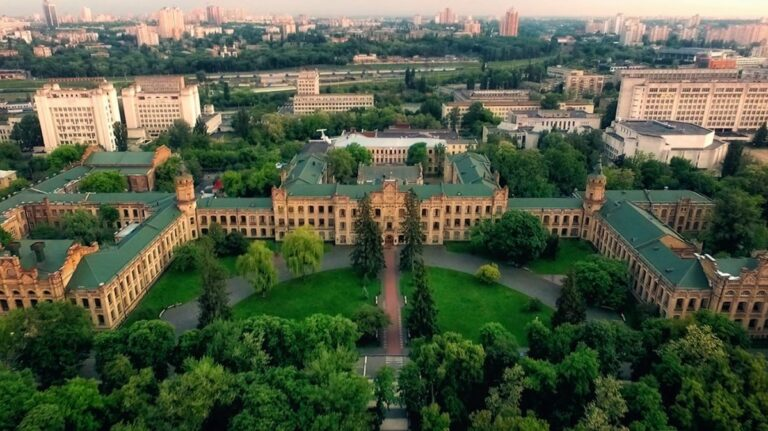

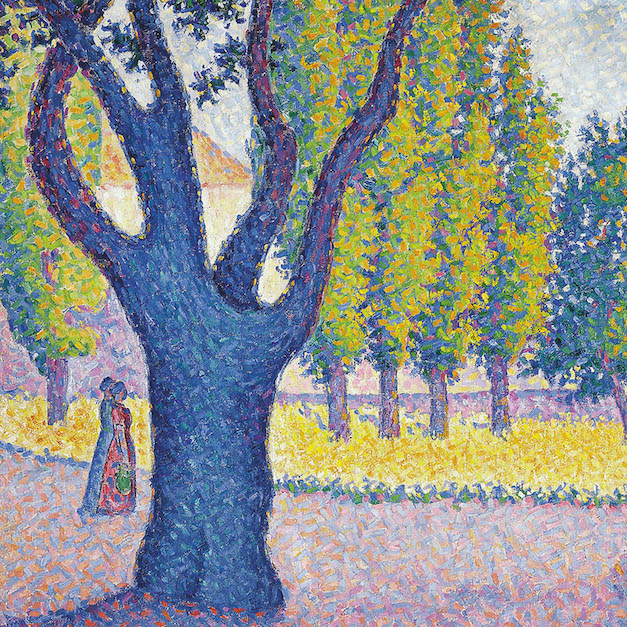

In [26]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [27]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [28]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 2s 0us/step


In [29]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [30]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [31]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [32]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=5658.80
Iteration 200: loss=4553.11
Iteration 300: loss=4092.57
Iteration 400: loss=3836.97
Iteration 500: loss=3671.60
Iteration 600: loss=3553.89
Iteration 700: loss=3465.00
Iteration 800: loss=3394.88
Iteration 900: loss=3337.63
Iteration 1000: loss=3289.95
Iteration 1100: loss=3249.62
Iteration 1200: loss=3214.84
Iteration 1300: loss=3184.45
Iteration 1400: loss=3157.67
Iteration 1500: loss=3133.87
Iteration 1600: loss=3112.51
Iteration 1700: loss=3093.24
Iteration 1800: loss=3075.81
Iteration 1900: loss=3059.93
Iteration 2000: loss=3045.43
Iteration 2100: loss=3032.13
Iteration 2200: loss=3019.87
Iteration 2300: loss=3008.55
Iteration 2400: loss=2998.08
Iteration 2500: loss=2988.35
Iteration 2600: loss=2979.30
Iteration 2700: loss=2970.88
Iteration 2800: loss=2963.04
Iteration 2900: loss=2955.72
Iteration 3000: loss=2948.88
Iteration 3100: loss=2942.46
Iteration 3200: loss=2936.45
Iteration 3300: loss=2930.81
Iteration 3400: loss=2925.50
Iteration 3500: loss=29

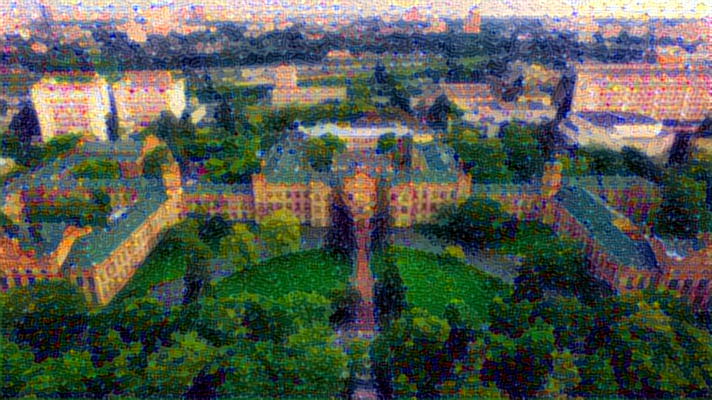

In [33]:
display(Image(result_prefix + "_at_iteration_4000.png"))